In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [2]:
plt.rcParams['font.family'] = 'SimHei' # 全局设置为黑体
plt.rcParams['font.size'] = 15

# 1 数据处理

## 1.1 预处理：观察

In [3]:
shfj = pd.read_csv('house.csv',index_col=0,na_values=['暂无资料','暂无资料年'])#读取，并指定索引、缺失值

In [4]:
shfj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 14 columns):
標題       240 non-null object
产权性质     228 non-null object
住宅类别     218 non-null object
建筑类别     188 non-null object
参考月供     0 non-null float64
年代       223 non-null object
建筑面积     240 non-null float64
户型       240 non-null object
楼层       228 non-null object
物 业 费    215 non-null object
物业类型     240 non-null object
结构       181 non-null object
装修       228 non-null object
總價       237 non-null float64
dtypes: float64(3), object(11)
memory usage: 17.8+ KB


In [5]:
shfj.head(1)

,標題,产权性质,住宅类别,建筑类别,参考月供,年代,建筑面积,户型,楼层,物 业 费,物业类型,结构,装修,總價
0,急售70年产权房源 房东装修 户型正气 产证清晰 随时看房,个人产权,普通住宅,板楼,NaN,1989年,70.4,2室2厅1厨1卫,中层(共6层),NaN,住宅,平层,精装修,30.6


## 1.2 缺失值处理
* 缺失值统计
* 根据需求，舍弃或填充缺失值
* 拆分字符串列

In [6]:
shfj.isnull().sum() # 缺失值统计

標題         0
产权性质      12
住宅类别      22
建筑类别      52
参考月供     240
年代        17
建筑面积       0
户型         0
楼层        12
物 业 费     25
物业类型       0
结构        59
装修        12
總價         3
dtype: int64

In [7]:
shfj.isnull().sum()/shfj.count()# 统计各列缺失值占比

標題       0.000000
产权性质     0.052632
住宅类别     0.100917
建筑类别     0.276596
参考月供          inf
年代       0.076233
建筑面积     0.000000
户型       0.000000
楼层       0.052632
物 业 费    0.116279
物业类型     0.000000
结构       0.325967
装修       0.052632
總價       0.012658
dtype: float64

In [8]:
shfj.drop('参考月供',axis=1,inplace=True) # 删除全为缺失值的列

###  1.2.1 【物业费】 列的处理
* 找规律，整理为单一数字
* 填充缺失值

In [9]:
(shfj['物 业 费'].dropna().str.contains('元/')).sum()# 寻找列中各元素 包含的 共同特征

215

In [10]:
shfj['物业费（元/平米）']=shfj['物 业 费'].str.split('元',expand=True)[0].astype(float)# 只取数组，创建新列

In [11]:
shfj['物业费（元/平米）'].fillna(shfj['物业费（元/平米）'].median(),inplace=True)# 缺失值填充为该列 中位数

### 1.2.2 【總價】 列的处理
* 缺失值填充为：每平米均价 * 建筑面积
* 0~1标准化

In [12]:
shfj['总价（万元）']=shfj['總價'].fillna((shfj['總價']/shfj['建筑面积']).mean()*shfj['建筑面积'])# 填充缺失值=每平米价格的平均值 * 建筑面积

In [13]:
shfj['均价（元/平米）']=shfj['总价（万元）']*10000/shfj['建筑面积'] # 注意单位

In [14]:
shfj['均价标准化'] = shfj[['均价（元/平米）']].apply(lambda x:(x-x.min())/(x.max() - x.min()),axis=0) # 0~1 标准化

### 1.2.3 【物业类型】 列的处理
* 创建虚拟变量

In [15]:
shfj['物业类型'].value_counts()

住宅    228
别墅     12
Name: 物业类型, dtype: int64

In [16]:
df = pd.get_dummies(shfj['物业类型']) # 创建虚拟变量 ，用于绘制 热力图
shfj = shfj.join(df) # 按索引连接 

### 1.2.4 【户型】【建筑年代】 列处理

In [17]:
shfj['建筑年代']=shfj['年代'].str.split('年',expand=True).get(0).astype(float)

In [18]:
(shfj['户型'].str.split('室').map(len)!=2).sum()# 寻找拆分规律

0

In [19]:
shfj['几室'] = shfj['户型'].str.split('室',expand=True)[0].astype(int)

In [20]:
shfj['几厅']=shfj['户型'].str.split('室',expand=True)[1].str.split('厅',expand=True)[0].astype(int)

### 1.3离散化
* 连续数据离散化，作为查看数据分布使用

In [21]:
shfj['总价分箱'] = pd.cut(shfj['总价（万元）'],bins=[0,50,100,500,1000,12345])

In [22]:
shfj['总价分位'] = pd.qcut(shfj['总价（万元）'],q=10,labels=list('abcdefghij'))

## 1.4 行列取舍——整理完毕

In [23]:
demos = shfj[['建筑年代','物业费（元/平米）','物业类型','总价（万元）',
              '均价（元/平米）','建筑面积','结构','住宅类别','产权性质','建筑类别','几室','几厅']]

# 2 数据分析

## 2.1 数据特征分析


* 相关性分析
* 集中趋势，离散趋势

## 2.1.1集中趋势、离散趋势

In [24]:
demos['总价（万元）'].describe()

count      240.000000
mean       642.626819
std       1292.586408
min         30.600000
25%        219.998355
50%        400.000000
75%        564.500000
max      11000.000000
Name: 总价（万元）, dtype: float64

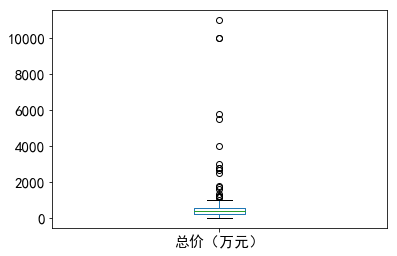

In [25]:
demos['总价（万元）'].plot.box()

In [26]:
demos['总价（万元）'].kurt() # 峰度

40.52782565750391

In [27]:
demos['总价（万元）'].skew() # 偏度

6.0171911532748075

### 2.1.2 相关性分析

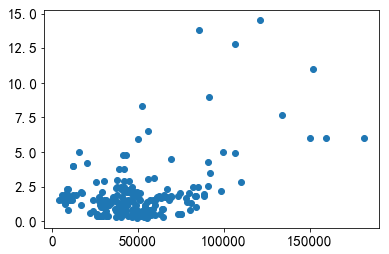

In [29]:
# pd.scatter_matrix(demos,figsize=(8,8),marker='+')
plt.scatter(demos['均价（元/平米）'],demos['物业费（元/平米）'])

In [30]:
u = demos['均价（元/平米）'].mean()
s = demos['均价（元/平米）'].std()
stats.kstest(demos['均价（元/平米）'],'norm',(u,s))#正态性检验

KstestResult(statistic=0.10648411593817408, pvalue=0.007990960793191837)

In [31]:
u1 = demos['物业费（元/平米）'].mean()
s1 = demos['物业费（元/平米）'].std()
stats.kstest(demos['物业费（元/平米）'],'norm',(u,s))#正态性检验

KstestResult(statistic=0.9515180129660263, pvalue=0.0)

In [32]:
demos[['均价（元/平米）','物业费（元/平米）']].corr(method='spearman')# 斯皮尔曼相关系数

,均价（元/平米）,物业费（元/平米）
均价（元/平米）,1.000000,0.096254
物业费（元/平米）,0.096254,1.000000


* 物业费与总价，斯皮尔曼相关系数低于0.3，不存在线性相关

## 2.2 可视化分析


* 三维度的散点图：

    
    
* 箱线图——分布分析

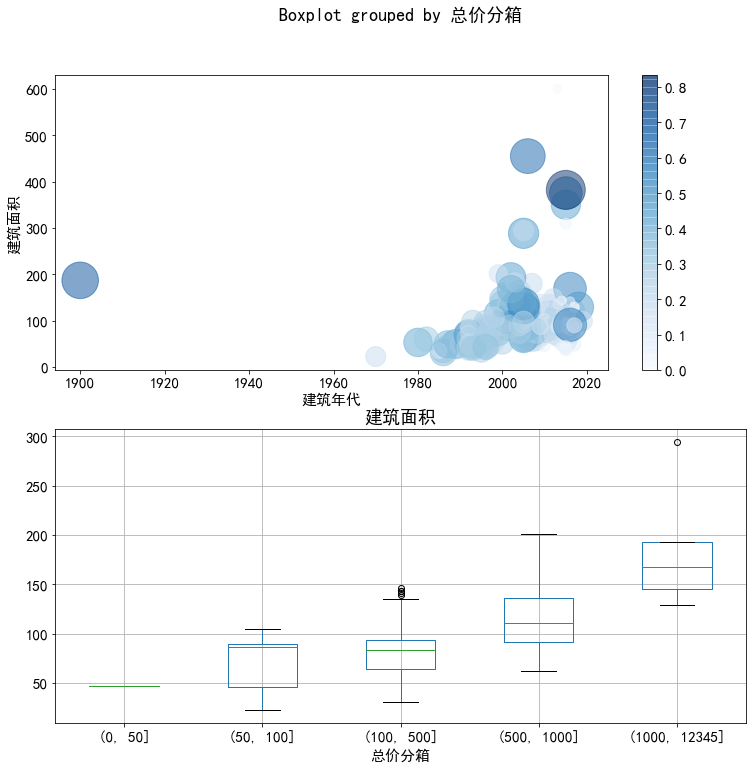

In [33]:
fig = plt.figure(figsize=(12,12))
ax1=fig.add_subplot(2,1,1)
shfj.plot.scatter(y='建筑面积',x='建筑年代',ax=ax1,c=shfj['均价标准化'],cmap='Blues',s=shfj['均价（元/平米）']/100,alpha=0.5)

ax2 = fig.add_subplot(2,1,2)
shfj.dropna().boxplot(column='建筑面积',by='总价分箱',ax=ax2)

* 各个装修的房屋成交总价分布
* 低于50平米的房屋成家量很少

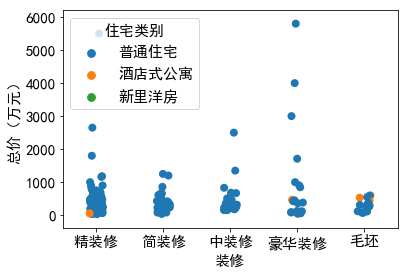

In [34]:
sns.stripplot(x='装修',y='总价（万元）',data=shfj,jitter=True,hue='住宅类别',size=8)

In [35]:
zj = shfj['总价分箱'].value_counts(normalize=True)

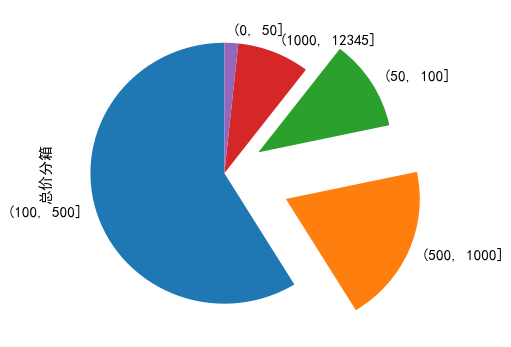

In [36]:
zj.plot.pie(figsize=(6,6),startangle=90,explode=(0,0.5,0.3,0,0))

# 设置表格样式
* 设置极值 背景高亮
* 缺失值填充为指定颜色
* 数字分类设置颜色

In [37]:
def colors(val):
    if val>50000:
        color='red'
    else:
        color='blue'
    return('color:%s'%color)

def colorss(val):
    if val>500:
        color='red'
    elif val<100:
        color = 'blue'        
    else:
        color='pink'
    return('color:%s'%color)


In [38]:
demos.head(11).style.\
    applymap(colors,subset=['均价（元/平米）']).\
    applymap(colorss,subset=['总价（万元）']).\
    highlight_max(color='#861000').\
    highlight_min(color='pink').\
    bar(color='#d65f5f',subset=['物业费（元/平米）']).\
    highlight_null(null_color='blue')

,建筑年代,物业费（元/平米）,物业类型,总价（万元）,均价（元/平米）,建筑面积,结构,住宅类别,产权性质,建筑类别,几室,几厅
0,1989,1.5,住宅,30.6,4346.59,70.4,平层,普通住宅,个人产权,板楼,2,2
1,1989,1,住宅,418,83902,49.82,平层,普通住宅,个人产权,塔楼,2,1
2,2005,3.5,住宅,2650,91918.1,288.3,nan,普通住宅,个人产权,nan,4,2
3,1994,0.4,住宅,280,50000,56,平层,nan,商品房,板楼,2,1
4,1998,0.4,住宅,190,32758.6,58,平层,普通住宅,个人产权,钢混,2,1
5,1986,0.85,住宅,205,58571.4,35,平层,nan,商品房,板楼,1,2
6,nan,3.8,别墅,1000,42194.1,237,nan,nan,nan,nan,4,3
7,1996,1.5,住宅,230,46000,50,平层,普通住宅,个人产权,板楼,1,1
8,1994,0.8,住宅,273,39674.5,68.81,平层,普通住宅,商品房,塔楼,2,1
9,1996,0.5,住宅,410,56944.4,72,平层,普通住宅,个人产权,板楼,2,1


In [39]:
demos.to_csv('上海房屋2017成交信息.csv',encoding='gbk',index=False)